# Data Analytics Final Portfolio Project - Beer Reviews

In this project I want to analyse a data set on beer reviews. The dataset is from Beer Advocate and contains 1.5 million beer reviews.
The dataset contains 10 columns: index, brewery_id, review_time, review_overall, review_aroma, review_appearance, review_palate, review_taste, beer_abv, and beer_beerid. 

Questions I want to answer:
1. Which Brewery has the best beers?
3. What are the best IPA's?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('beer_reviews.csv')
df.head(5)
#Get a gist of the DF.
df.info()
#See data types - they are all correct.
df.describe()
#See statistics of raw DF.

**Fixing missing values**

The beer_abv column has 67785 missing values, brewey_name has 15 missing values and the review_profile name has 348 missing values.

To fill missing brewery names I created a table that appends the most common brewery name using the brewery id. Sometimes there are typos so taking the mode ensures consistency, it also avoids throwing away and unecessary rows.

I replaced missing profile names with 'n/a' as it does not concern my problems.

To fill missing brewery names I found the median for each beer_id and brewery_id pair. Using the median reduces the effect of breweries that change ABV with vintage versions for example.

After fixing missing values there were 67800 less reviews.

In [16]:
brewery_map = (df[['brewery_id', 'brewery_name']].dropna().groupby('brewery_id')['brewery_name']
.agg(lambda x: x.mode().iloc[0]).to_dict())
#Selects only the brewery id and brewery name.
#Drops missing values as they can't be used for mapping.
#Groups by brewery idm looking at all brewery names that appear for that id.
#Takes the mode brewery name for each id.
#Converts to a dictionary mapping.a
df['brewery_name'] = df.apply(lambda row: brewery_map.get(row['brewery_id'], None) 
if pd.isna(row['brewery_name']) else row['brewery_name'],axis=1)
#Loops through rows, if brewery name is missing look up the name using the rows brewery id in the brewery map.
#Otherwise, keep existing name.
df = df.dropna(subset=['brewery_name'])
#If after filling we still dont know the name, drop that row.
df['review_profilename'] = df['review_profilename'].fillna('n/a')
#Replaces missing reviewer names with 'n/a'.
abv_map = (df.groupby(['beer_beerid', 'brewery_id'])['beer_abv'].median().reset_index())
#Groups by beer id and brewery id.
#Calculates the median ABV wihtin each group.
df = df.merge(abv_map, on=['beer_beerid', 'brewery_id'], suffixes=('', '_median'))
#Merges DF with abv_map on beer id and brewery id.
#New median ABV column is created.
df['beer_abv'] = df['beer_abv'].fillna(df['beer_abv_median'])
#If original beer abv is missing replace it with group median.
df = df.dropna(subset=['beer_abv'])
#If there is no ABV drop the row.
df = df.drop(columns=['beer_abv_median'])
#Remove temporary median column.
df = df.reset_index(drop=True)
#Reset DF index

**Determining what kind of analysis I need**

For Q1 i have decided to calculate the mean of each beer's overall score for each brewery, if the brewery had <= 50 reviews it would be dropped. I implemented a weighted average so that if a brewery has lots of reviews it's weighted score average will be close to it's own and if the brewery has a small amount of reviews it's weighted score average will be pulled towards the global weighted score average, this way small breweries don't domminate.

For Q2 i have decided to calculate the average overall score for each IPA beer, a weighted average was also implemented.


   
**Q1. Which Brewery has the best beers?**

In [4]:
brewery_counts = df.groupby("brewery_id").size().reset_index(name="review_count")
#Groups the dataset by brewery_id, counts how many reviews each brewery has.
#Turns it back into a DF with two colums, brewery_id and review_count.
valid_breweries = brewery_counts[brewery_counts["review_count"] >= 50]
#Filters breweries to keep only those with at least 50 reviews.
df_filtered = df[df["brewery_id"].isin(valid_breweries["brewery_id"])]
#Filters the orignal DF so it only includes reviews from the valid breweries.
C = df_filtered["review_overall"].mean()
#C is the global average rating across all valid breweries, acts like a baseline.
m = 50 
#m is the minimum number of reviews required for a brewery to be considered reliable.
#Acts like a balancing factor in the weighted average formula.
brewery_stats = df_filtered.groupby("brewery_name").agg(review_count=("review_overall", "count"),
mean_overall=("review_overall", "mean")).reset_index()
#Groups by brewery_name
brewery_stats["weighted_average"] = ((brewery_stats["review_count"] / (brewery_stats["review_count"] + m))
* brewery_stats["mean_overall"]+ (m / (brewery_stats["review_count"] + m)) * C)
#This is the weighted average formula.
brewery_stats["mean_overall"] = brewery_stats["mean_overall"].round(2)
brewery_stats["weighted_average"] = brewery_stats["weighted_average"].round(2)
#Rounds both the mean rating adn weighted average.
brewery_stats_sorted = brewery_stats.sort_values("weighted_average", ascending=False).reset_index(drop=True)
#Sorts breweries from highest to lowest weighted average.
brewery_stats_sorted.head(10)

,brewery_name,review_count,mean_overall,weighted_average
0,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,2378,4.54,4.53
1,The Alchemist,527,4.58,4.52
2,Russian River Brewing Company,11311,4.37,4.37
3,Bayerische Staatsbrauerei Weihenstephan,6269,4.29,4.28
4,Hill Farmstead Brewery,1531,4.30,4.28
5,Brouwerij Drie Fonteinen,1668,4.29,4.28
6,Kern River Brewing Company,929,4.29,4.27
7,Live Oak Brewing Company,584,4.31,4.27
8,Närke Kulturbryggeri AB,212,4.36,4.26
9,Brasserie de Rochefort,4494,4.27,4.26


This code ranks breweries based on review data while correcting for bias from breweries with very few reviews. First, it counts how many reviews each brewery has and filters out breweries with fewer than 50 reviews to ensure reliability. It then calculates the global average rating across all remaining breweries to serve as a baseline. For each brewery, it computes both the raw average rating and a weighted average rating that balances the brewery’s own mean with the global mean, depending on how many reviews it has (using 50 as the balancing factor). Finally, it rounds the results, sorts breweries by their weighted average rating from highest to lowest, and returns the top 10, giving a fairer ranking that doesn’t let small sample sizes dominate.

**Q2. What are the best IPA's?**

In [5]:
C = df["review_overall"].mean()
#Calculates the global average overall rating across all beers.
m = 50 
#Set the minimum review threshold.
ipa_best = (df[df["beer_style"].str.contains("IPA", case=False)]
.groupby(["beer_style", "beer_name", "brewery_name"]).agg(avg_overall=("review_overall", "mean"),
avg_taste=("review_taste", "mean"),review_count=("review_overall", "count")).reset_index())
#Keeps only rows where beer style contains 'IPA'.
#Groups reviews by style, name and brewery.
#Calculates mean overall, mean taste and count of reviews.
ipa_best = ipa_best[ipa_best["review_count"] >= 10]
#Removes beers with fewer than 10 reviews.
ipa_best["weighted_overall"] = ((ipa_best["review_count"] / (ipa_best["review_count"] + m)) * ipa_best["avg_overall"]
+ (m / (ipa_best["review_count"] + m)) * C)
#Calculates the weighted rating for each beer.
ipa_best_per_style = ( ipa_best.sort_values(["beer_style", "weighted_overall"], ascending=[True, False])
.groupby("beer_style").first().reset_index())
#Within each style, sorts beers from highest to lowest weighted rating.
#Picks the top beer for each style.
top20_ipa = (ipa_best_per_style.sort_values("weighted_overall", ascending=False).head(20))
#Selects top 20 and sorts.
top20_ipa["avg_overall"] = top20_ipa["avg_overall"].round(2)
top20_ipa["avg_taste"] = top20_ipa["avg_taste"].round(2)
top20_ipa["weighted_overall"] = top20_ipa["weighted_overall"].round(2)
#Rounds columns to 2 decimal places.
top20_ipa = top20_ipa.rename(columns={"beer_style": "Best IPA's"})
#Renames columns.
top20_ipa

,Best IPA's,beer_name,brewery_name,avg_overall,avg_taste,review_count,weighted_overall
0,American Double / Imperial IPA,Pliny The Elder,Russian River Brewing Company,4.59,4.63,2527,4.58
1,American IPA,Masala Mama India Pale Ale,Minneapolis Town Hall Brewery,4.49,4.40,662,4.44
2,Belgian IPA,Bitter Monk,Anchorage Brewing Company,4.31,4.32,113,4.16
3,English India Pale Ale (IPA),Jaipur IPA,Thornbridge Brewery,4.18,4.10,100,4.06


This code identifies and ranks the best IPA beers in the dataset using a fair scoring method. It first calculates the global average rating across all beers (C) and sets a balancing constant (m = 50) for the weighted formula. The dataset is filtered to include only beers with “IPA” in their style, then grouped by beer style, beer name, and brewery to calculate average overall rating, average taste rating, and review counts. Beers with fewer than 10 reviews are excluded to ensure reliability. For each beer, a weighted overall rating is computed, blending its own average rating with the global average so that beers with few reviews don’t get unfairly high rankings. Next, the code picks the top-rated beer within each IPA sub-style, then selects the top 20 IPAs overall based on weighted rating.

**Visualising findigs**

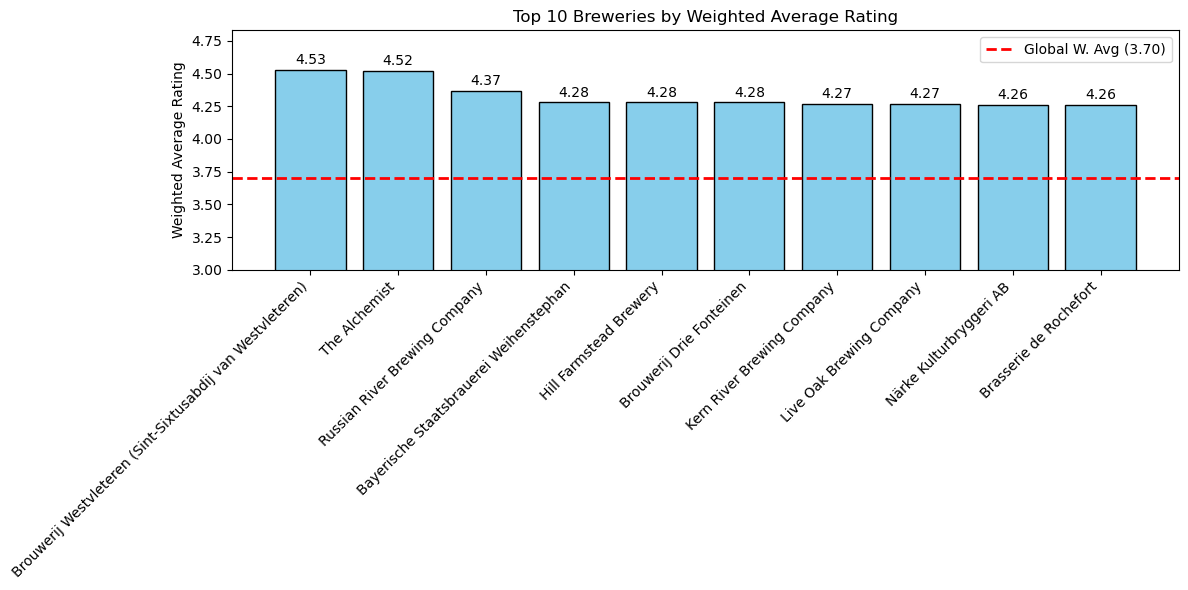

In [6]:
top_n = 10
plot_data = brewery_stats_sorted.head(top_n)
#Defines how many breweries to plot.
global_weighted_avg = brewery_stats_sorted["weighted_average"].mean()
#Calculates the over all mean of weighted averages across all breweries.
plt.figure(figsize=(12, 6))
bars = plt.bar(plot_data["brewery_name"], plot_data["weighted_average"],
color="skyblue",edgecolor="black")
#Plots bars.
for bar in bars:height = bar.get_height()
plt.text(bar.get_x() + bar.get_width() / 2,
height + 0.02,f"{height:.2f}",
ha="center", va="bottom", fontsize=10)
#Loops over ach bar, gets the hegiht and adds a label above the bar.
plt.axhline(global_weighted_avg, color="red", linestyle="--", linewidth=2, label=f"Global W. Avg ({global_weighted_avg:.2f})")
#Draws a horizontal red dased line at the weighted global average.
plt.xticks(rotation=45, ha="right")
plt.ylabel("Weighted Average Rating")
plt.title("Top 10 Breweries by Weighted Average Rating")
plt.ylim(3, plot_data["weighted_average"].max() + 0.3)  
#Styling
plt.legend()
plt.tight_layout()
plt.show()
#Display